In [191]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
from photutils.datasets import make_gaussian_sources_image, make_noise_image
from astropy.table import Table
from tqdm import tqdm, trange

%matplotlib inline

In [64]:
fn = '../data/1551210093509O-result.csv' #stars in pi deg^2
dataset = Table.read(fn, )

In [341]:
arcsec_per_pixel = 4 * u.arcsec
image_shape = (500, 500) # pixels
image_area = (image_shape[0] * image_shape[1] * arcsec_per_pixel * arcsec_per_pixel).to(u.degree*u.degree)
print(image_area)

throughput = 0.8
QE = 0.9 * u.ct/u.photon
lam = 0.4*u.um
dlam = 0.15*u.um

mirror_diameter = 0.3 * u.m
mirror_area = mirror_diameter**2 * np.pi

texp = 600 * u.s
texp_sub = 60 * u.s

mag_target = 21
mag_host = mag_target - 5

zodi_per_arcsec = 4.e-6 * u.Jy 
zodi_per_pixel = (zodi_per_arcsec * arcsec_per_pixel.value**2*c.c/lam**2*dlam*mirror_area/(c.h*c.c/lam/u.photon)
                 ).to(u.photon/u.s)

zodi_ct_per_pixel = zodi_per_pixel * throughput * QE
print(zodi_ct_per_pixel.to(u.ct/u.s))

psf_oversample = 2

galaxy_shape = [10,15]
target_dist_arcsec = 15
target_dist_pixels = target_dist_arcsec / arcsec_per_pixel

0.30864197530864196 deg2
73.73608889384523 ct / s


In [342]:
# convert to Jy (10−23 erg s−1 Hz−1 cm−2)
bgstarsflux = 10**((dataset['phot_g_mean_mag'] - 8.9) / -2.5) * u.Jansky
bgstars_photons = bgstarsflux.to(u.photon / u.cm**2 / u.s / u.um,
                  equivalencies=u.spectral_density(0.4 * u.um)) * mirror_area.to(u.cm**2) * dlam
bgstars_cnts = bgstars_photons * throughput * QE * texp

flux_host = 10**((mag_host - 8.9) / -2.5) * u.Jansky
flux_target = 10**((mag_target - 8.9) / -2.5) * u.Jansky

photons_host = flux_host.to(u.photon / u.cm**2 / u.s / u.um,
                  equivalencies=u.spectral_density(0.4 * u.um)) * mirror_area.to(u.cm**2) * dlam
cnts_host = photons_host * throughput * QE * texp

photons_target = flux_target.to(u.photon / u.cm**2 / u.s / u.um,
                  equivalencies=u.spectral_density(0.4 * u.um)) * mirror_area.to(u.cm**2) * dlam
cnts_target = photons_target * throughput * QE * texp

nstars_per_square_degree = int(len(dataset) // np.pi)
nstars_per_square_degree *= image_area.value 
nstars_per_square_degree = np.int(nstars_per_square_degree)
x_stddev = 6 * u.arcsec
y_stddev = 6 * u.arcsec


In [343]:
np.random.seed(42)

table_bgstars = Table()
table_bgstars['flux'] = np.random.choice(bgstars_cnts, nstars_per_square_degree) 
table_bgstars['x_mean'] = np.random.uniform(high=image_shape[0], size=nstars_per_square_degree) # * u.pixel
table_bgstars['y_mean'] = np.random.uniform(high=image_shape[1], size=nstars_per_square_degree) # * u.pixel
table_bgstars['x_stddev'] = (np.zeros(nstars_per_square_degree) + x_stddev) / arcsec_per_pixel
table_bgstars['y_stddev'] = (np.zeros(nstars_per_square_degree) + y_stddev) / arcsec_per_pixel
table_bgstars['theta'] = np.zeros(nstars_per_square_degree) * u.radian

In [ ]:
image_bgstars = make_gaussian_sources_image(image_shape, table_bgstars, oversample=psf_oversample)

In [ ]:
image_zodi = make_noise_image(image_shape, type='poisson', mean=zodi_ct_per_pixel.value*texp.value, )


In [ ]:
table_target = Table()
table_target['flux'] = [cnts_target.value, cnts_host.value]
gpos = [np.random.uniform(high=image_shape[0]), np.random.uniform(high=image_shape[1])]
table_target['x_mean'] = [gpos[0] + np.random.uniform(low=target_dist_pixels.value, high=target_dist_pixels.value),
                          gpos[0]]
table_target['y_mean'] = [gpos[1] + np.random.uniform(low=target_dist_pixels.value, high=target_dist_pixels.value),
                          gpos[1]]
table_target['x_stddev'] = [(x_stddev / arcsec_per_pixel).value, (galaxy_shape[0]/ arcsec_per_pixel).value] 
table_target['y_stddev'] = [(y_stddev/ arcsec_per_pixel).value, (galaxy_shape[1]/ arcsec_per_pixel).value] 
table_target['theta'] = np.random.uniform(high=2*np.pi, size=2) * u.radian

image_target = make_gaussian_sources_image(image_shape, table_target, oversample=psf_oversample)

In [ ]:
fig, ax = plt.subplots(figsize=[12,12])
im = ax.imshow(image_bgstars+image_zodi+image_target, origin='lower', interpolation='nearest')

plt.scatter(table_target['x_mean'], table_target['y_mean'])
fig.colorbar(im)

In [ ]:
fig, ax = plt.subplots(figsize=[12,12])
im = ax.imshow(image_target, origin='lower', interpolation='nearest')
fig.colorbar(im)

In [55]:
len(dataset)

280988

In [57]:
len(dataset) // np.pi

89441.0

In [291]:
photons_host, photons_target

(<Quantity 2312.95736602 ph / s>, <Quantity 23.12957366 ph / s>)

(array([2.57095e+05, 1.30000e+01, 2.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.38770e+04]),
 array([7.29435339e-07, 1.00000066e+00, 2.00000058e+00, 3.00000051e+00,
        4.00000044e+00, 5.00000036e+00, 6.00000029e+00, 7.00000022e+00,
        8.00000015e+00, 9.00000007e+00, 1.00000000e+01]),
 <a list of 10 Patch objects>)

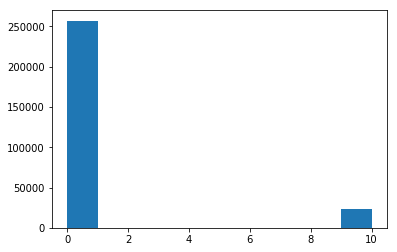

In [187]:
plt.hist(bgstarsflux.value)

In [331]:
table_target

flux,x_mean,y_mean,x_stddev,y_stddev,theta
,,,,,rad
float64,float64,float64,float64,float64,float64
9991.975821226972,67.5121343551194,14.026560972867262,1.5,1.5,1.7927144186988604
999197.5821226973,31.30566872163897,98.68304343061747,2.5,3.75,3.3391164758184657


In [209]:
bgstarsflux[0].to(u.photon / u.cm**2 / u.s / u.um, equivalencies=u.spectral_density(0.4 * u.um)) * mirror_area.to(u.cm**2) * 400*u.um

<Quantity 5.08114467e+09 ph / s>

In [249]:
table_bgstars

<Table length=0>
<No columns>

In [267]:
zodi_per_pixel*throughput*QE

<Quantity 73.73608889 ct / s>

In [329]:
target_dist_pixels

<Quantity 3.75 1 / arcsec>

In [297]:
cnts_target

<Quantity 9991.97582123 ct>

In [306]:
(x_stddev / arcsec_per_pixel).value

1.5

In [320]:
target_dist_pixels

<Quantity 60. arcsec>

In [334]:
[np.random.uniform(high=image_shape[0]) + np.random.uniform(high=target_dist_pixels.value),
                          np.random.uniform(high=image_shape[0])]

[15.775840640658434, 34.54617730632788]